<a href="https://colab.research.google.com/github/sumico2019/ps/blob/main/nikkei.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Best parameter =  RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=5, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)
              precision    recall  f1-score   support

           0       0.29      0.47      0.36      1201
           1       0.69      0.51      0.59      2799

    accuracy                           0.50      4000
   macro avg       0.49      0.49      0.47      4000
weighted avg       0.57      0.50      0.52      4000

Accuracy [%] =  0.49625
2021.10.28. 15:37:43    Analysis have done


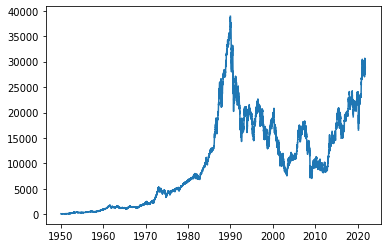

In [ ]:
import pandas_datareader.data as web
import pandas as pd
import datetime
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score


#Get Nikkei stock average from web
nikkei = web.DataReader("NIKKEI225", "fred", "1950/1/1")
plt.plot(nikkei)

# データをCSV出力する
nikkei.to_csv('nikkei.csv')

#Transform to Logarithmic rate of return
nikkei['log_change']=np.log(nikkei['NIKKEI225'])-np.log(nikkei['NIKKEI225'].shift(1))
nikkei2=nikkei['log_change'].values

#Reshape for matrix with 7days data + 8th-day data as one line
term = 7
pricedata = []

length=len(nikkei2)
for i in range(0,length-term-1):
    pricedata.append(nikkei2[i:i+term+1])

df=pd.DataFrame(np.array(pricedata).reshape(-1,8))
df.columns = ['1st_day', '2nd_day', '3rd_day','4th_day', '5th_day', '6th_day','7th_day','8th_day_pred']

#Delete N/A data
df=df.dropna()
df=df.reset_index(drop=True)

#Transfrom to boolian based on the increase/decrease from 1 day before
for i in range(1,len(df)):
    if df['8th_day_pred'][i]>0:
        df['8th_day_pred'][i]=1
    elif df['8th_day_pred'][i]<0:
        df['8th_day_pred'][i]=0

#Separate conditions and answer
x=np.array(df.drop(['8th_day_pred'],axis=1))
y=np.array(df['8th_day_pred'], dtype=np.int16)

#Separate train data and test data
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=0,shuffle=False)

#Set grid search condition
grid_param = [{"n_estimators": [50,100],
               "max_depth"   : [None,5],
              }]

#Set cross validation condition
kfold_cv = KFold(n_splits=5, shuffle=True)

#Set algorizm
clf = GridSearchCV(RandomForestClassifier(), grid_param, cv=kfold_cv)

#Machine learning
clf.fit(x_train, y_train)
print("Best parameter = ", clf.best_estimator_)

#Prediction
y_pred = clf.predict(x_test)

#output
print(classification_report(y_pred, y_test))
print("Accuracy [%] = " , accuracy_score(y_test, y_pred))
print(datetime.datetime.now().strftime('%Y.%m.%d. %H:%M:%S'), "   Analysis have done")